# CutMix, Mixup 비교실험

데이터 증강이 이미지 분류 성능 변화에 어떤 영향을 주는가를 확인하는 실험을 진행합니다. 네트워크는 ImageNet 데이터를 사용하여 사전학습이 완료된 ResNet-50을 사용하고, 데이터는 120 종의 강아지를 분류하는 데이터셋 [Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/main.html)을 사용합니다.

## 데이터셋 준비

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    "stanford_dogs",
    split=["train", "test"],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

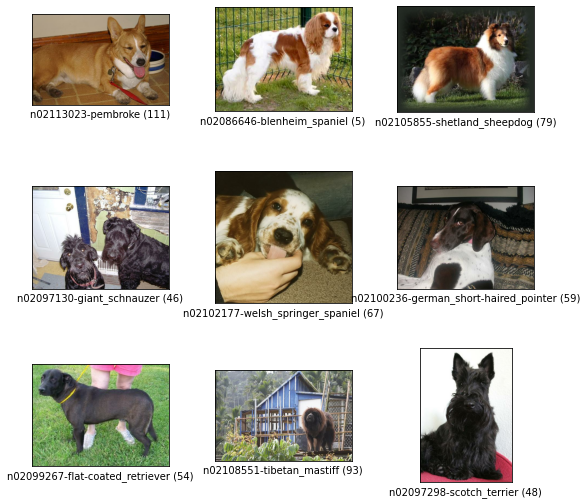

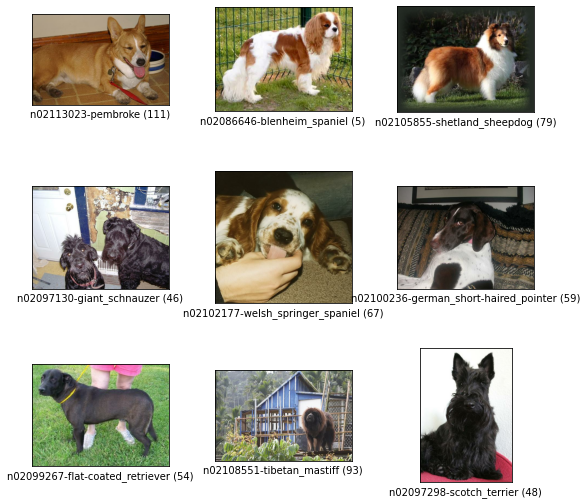

In [3]:
tfds.show_examples(ds_train, ds_info)

### CutMix 구현

[CutMix](https://arxiv.org/abs/1905.04899)는 지역적인 특징을 사용하여 분류기의 성능을 강화하는 데이터 증강 방법입니다.  
- 이미지의 일부를 잘라내고, 다른 클래스에 속하는 이미지의 일부 영역을 잘라서 채우는 방법을 사용하여 데이터를 증강합니다.
- 이미지의 일부 영역 정보를 사용하지 않는 Cutout 방법과 서로 다른 이미지를 blending하여 사용하는 Mixup 방법과 비교하여 더 좋은 성능을 보였습니다.

특정 이미지를 자르는 함수를 구현합니다.

In [4]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(
        image_size_x * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32
    )
    height = tf.cast(
        image_size_y * tf.math.sqrt(1 - tf.random.uniform([], 0, 1)), tf.int32
    )

    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x - width // 2)
    y_min = tf.math.maximum(0, y - height // 2)
    x_max = tf.math.minimum(image_size_x, x + width // 2)
    y_max = tf.math.minimum(image_size_y, y + width // 2)

    return x_min, y_min, x_max, y_max

잘라낸 이미지를 다른 이미지의 빈 공간에 채워넣는 함수를 구현합니다.

In [5]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    middle_left = image_a[y_min:y_max, 0:x_min, :]  # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :]  # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left, middle_center, middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom], axis=0)

    return mixed_img

이미지가 잘라지고 채워넣어진 영역의 비율만큼 라벨의 비율을 조절하는 함수를 구현합니다.

In [6]:
# mix two labels
def mix_2_labels(
    image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120
):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = tf.cast(mixed_area / total_area, tf.float32)

    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    return mixed_label

앞서 정의한 함수들을 사용하여 이미지를 잘라서 채워넣고 라벨을 수정하는 함수를 구현합니다.

In [7]:
def cutmix(image, label, prob=1.0, batch_size=32, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(
            mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max)
        )

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### mixup 구현

[mixup](https://arxiv.org/abs/1710.09412)은 서로 다른 2개의 이미지를 blending 하여 데이터를 증강하는 방법입니다.

In [8]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)

    if len(label_a.shape) == 0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape) == 0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image = (1 - ratio) * image_a + ratio * image_b
    mixed_label = (1 - ratio) * label_a + ratio * label_b

    return mixed_image, mixed_label

In [9]:
def mixup(image, label, prob=1.0, batch_size=32, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 데이터 증강 적용

In [10]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

In [11]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255.0, label


def onehot(img, label):
    return img, tf.one_hot(label, num_classes)


def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label


def apply_normalize_on_dataset(
    ds,
    is_test=False,
    batch_size=32,
    with_aug=False,
    with_cutmix=False,
    with_mixup=False,
):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    if is_test:
        with_aug = False
        with_cutmix = False
        with_mixup = False

    if with_aug:
        ds = ds.map(augment)
    ds = ds.batch(batch_size)

    if with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls=2)
    elif with_mixup:
        ds = ds.map(mixup, num_parallel_calls=2)
    else:
        ds = ds.map(onehot, num_parallel_calls=2)

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

총 6가지의 데이터셋을 준비합니다.
- 데이터 증강을 적용하지 않은 데이터셋
- 데이터 증강을 적용한 데이터셋
- CutMix를 적용한 데이터셋
- mixup을 적용한 데이터셋
- 데이터 증강과 CutMix를 적용한 데이터셋
- 데이터 증강과 mixup을 적용한 데이터셋

In [12]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cut = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mix = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_train_aug_cut = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_aug_mix = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [13]:
ds_train_no_aug

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.float32)>

## 모델 준비

6가지 종류의 데이터셋에 대한 실험을 위해 6개의 모델을 준비하고 각각에 대한 훈련을 진행합니다.

In [14]:
resnet50 = keras.models.Sequential(
    [
        keras.applications.resnet.ResNet50(
            include_top=False,
            weights="imagenet",
            input_shape=(224, 224, 3),
            pooling="avg",
        ),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

In [15]:
resnet50_aug = keras.models.Sequential(
    [
        keras.applications.resnet.ResNet50(
            include_top=False,
            weights="imagenet",
            input_shape=(224, 224, 3),
            pooling="avg",
        ),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

In [16]:
resnet50_cut = keras.models.Sequential(
    [
        keras.applications.resnet.ResNet50(
            include_top=False,
            weights="imagenet",
            input_shape=(224, 224, 3),
            pooling="avg",
        ),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

In [17]:
resnet50_mix = keras.models.Sequential(
    [
        keras.applications.resnet.ResNet50(
            include_top=False,
            weights="imagenet",
            input_shape=(224, 224, 3),
            pooling="avg",
        ),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

In [18]:
resnet50_aug_cut = keras.models.Sequential(
    [
        keras.applications.resnet.ResNet50(
            include_top=False,
            weights="imagenet",
            input_shape=(224, 224, 3),
            pooling="avg",
        ),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

In [19]:
resnet50_aug_mix = keras.models.Sequential(
    [
        keras.applications.resnet.ResNet50(
            include_top=False,
            weights="imagenet",
            input_shape=(224, 224, 3),
            pooling="avg",
        ),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

## 모델 학습

데이터셋을 제외한 나머지 요소들은 동일하게 적용하고 6개의 모델에 대한 훈련을 진행합니다.

In [20]:
EPOCH = 15

In [21]:
resnet50.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits["train"].num_examples / 16),
    validation_steps=int(ds_info.splits["test"].num_examples / 16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 166s 206ms/step - loss: 2.2015 - accuracy: 0.4504 - val_loss: 3.5649 - val_accuracy: 0.1782
Epoch 2/15
750/750 [==============================] - 153s 205ms/step - loss: 0.7304 - accuracy: 0.7972 - val_loss: 1.0618 - val_accuracy: 0.6877
Epoch 3/15
750/750 [==============================] - 154s 205ms/step - loss: 0.2226 - accuracy: 0.9553 - val_loss: 0.9530 - val_accuracy: 0.7229
Epoch 4/15
750/750 [==============================] - 153s 205ms/step - loss: 0.0666 - accuracy: 0.9933 - val_loss: 0.8879 - val_accuracy: 0.7439
Epoch 5/15
750/750 [==============================] - 153s 205ms/step - loss: 0.0274 - accuracy: 0.9993 - val_loss: 0.9140 - val_accuracy: 0.7376
Epoch 6/15
750/750 [==============================] - 154s 205ms/step - loss: 0.0189 - accuracy: 0.9992 - val_loss: 0.9083 - val_accuracy: 0.7451
Epoch 7/15
750/750 [==============================] - 154s 205ms/step - loss: 0.0127 - accuracy: 0.9997 - val_loss: 0.9218 -

In [22]:
resnet50_aug.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"],
)

history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits["train"].num_examples / 16),
    validation_steps=int(ds_info.splits["test"].num_examples / 16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 161s 206ms/step - loss: 2.2900 - accuracy: 0.4236 - val_loss: 3.0474 - val_accuracy: 0.2536
Epoch 2/15
750/750 [==============================] - 154s 205ms/step - loss: 0.9547 - accuracy: 0.7270 - val_loss: 1.2120 - val_accuracy: 0.6533
Epoch 3/15
750/750 [==============================] - 154s 205ms/step - loss: 0.5164 - accuracy: 0.8564 - val_loss: 1.0502 - val_accuracy: 0.6933
Epoch 4/15
750/750 [==============================] - 154s 205ms/step - loss: 0.2669 - accuracy: 0.9358 - val_loss: 1.0009 - val_accuracy: 0.7100
Epoch 5/15
750/750 [==============================] - 154s 205ms/step - loss: 0.1419 - accuracy: 0.9709 - val_loss: 0.9648 - val_accuracy: 0.7236
Epoch 6/15
750/750 [==============================] - 154s 205ms/step - loss: 0.0814 - accuracy: 0.9877 - val_loss: 0.9852 - val_accuracy: 0.7267
Epoch 7/15
750/750 [==============================] - 154s 205ms/step - loss: 0.0537 - accuracy: 0.9924 - val_loss: 0.9704 -

In [23]:
resnet50_cut.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"],
)

history_resnet50_cut = resnet50_cut.fit(
    ds_train_cut,
    steps_per_epoch=int(ds_info.splits["train"].num_examples / 16),
    validation_steps=int(ds_info.splits["test"].num_examples / 16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 163s 208ms/step - loss: 3.8157 - accuracy: 0.2143 - val_loss: 3.6386 - val_accuracy: 0.1621
Epoch 2/15
750/750 [==============================] - 155s 206ms/step - loss: 2.9503 - accuracy: 0.4355 - val_loss: 1.4729 - val_accuracy: 0.5868
Epoch 3/15
750/750 [==============================] - 155s 207ms/step - loss: 2.6414 - accuracy: 0.5256 - val_loss: 1.3317 - val_accuracy: 0.6328
Epoch 4/15
750/750 [==============================] - 155s 207ms/step - loss: 2.4240 - accuracy: 0.6019 - val_loss: 1.2581 - val_accuracy: 0.6549
Epoch 5/15
750/750 [==============================] - 170s 226ms/step - loss: 2.2755 - accuracy: 0.6503 - val_loss: 1.2781 - val_accuracy: 0.6516
Epoch 6/15
750/750 [==============================] - 155s 207ms/step - loss: 2.1760 - accuracy: 0.6785 - val_loss: 1.3038 - val_accuracy: 0.6465
Epoch 7/15
750/750 [==============================] - 155s 207ms/step - loss: 2.0770 - accuracy: 0.7098 - val_loss: 1.1827 -

In [24]:
resnet50_mix.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"],
)

history_resnet50_mix = resnet50_mix.fit(
    ds_train_mix,
    steps_per_epoch=int(ds_info.splits["train"].num_examples / 16),
    validation_steps=int(ds_info.splits["test"].num_examples / 16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 163s 208ms/step - loss: 3.7142 - accuracy: 0.2358 - val_loss: 4.0029 - val_accuracy: 0.1157
Epoch 2/15
750/750 [==============================] - 155s 207ms/step - loss: 2.8484 - accuracy: 0.4893 - val_loss: 1.4175 - val_accuracy: 0.6163
Epoch 3/15
750/750 [==============================] - 155s 207ms/step - loss: 2.5631 - accuracy: 0.5856 - val_loss: 1.3516 - val_accuracy: 0.6194
Epoch 4/15
750/750 [==============================] - 155s 207ms/step - loss: 2.3572 - accuracy: 0.6716 - val_loss: 1.2021 - val_accuracy: 0.6688
Epoch 5/15
750/750 [==============================] - 155s 207ms/step - loss: 2.2459 - accuracy: 0.7103 - val_loss: 1.2324 - val_accuracy: 0.6637
Epoch 6/15
750/750 [==============================] - 155s 206ms/step - loss: 2.1409 - accuracy: 0.7505 - val_loss: 1.2938 - val_accuracy: 0.6649
Epoch 7/15
750/750 [==============================] - 155s 207ms/step - loss: 2.0556 - accuracy: 0.7765 - val_loss: 1.1899 -

In [25]:
resnet50_aug_cut.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"],
)

history_resnet50_aug_cut = resnet50_aug_cut.fit(
    ds_train_aug_cut,
    steps_per_epoch=int(ds_info.splits["train"].num_examples / 16),
    validation_steps=int(ds_info.splits["test"].num_examples / 16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 163s 208ms/step - loss: 3.8654 - accuracy: 0.2045 - val_loss: 3.1261 - val_accuracy: 0.2444
Epoch 2/15
750/750 [==============================] - 155s 207ms/step - loss: 3.0524 - accuracy: 0.4030 - val_loss: 1.3268 - val_accuracy: 0.6220
Epoch 3/15
750/750 [==============================] - 155s 206ms/step - loss: 2.7788 - accuracy: 0.4782 - val_loss: 1.2159 - val_accuracy: 0.6562
Epoch 4/15
750/750 [==============================] - 155s 206ms/step - loss: 2.5802 - accuracy: 0.5408 - val_loss: 1.4444 - val_accuracy: 0.6026
Epoch 5/15
750/750 [==============================] - 155s 207ms/step - loss: 2.4499 - accuracy: 0.5872 - val_loss: 1.3361 - val_accuracy: 0.6491
Epoch 6/15
750/750 [==============================] - 155s 206ms/step - loss: 2.3489 - accuracy: 0.6146 - val_loss: 1.1507 - val_accuracy: 0.6809
Epoch 7/15
750/750 [==============================] - 155s 206ms/step - loss: 2.2547 - accuracy: 0.6450 - val_loss: 1.2120 -

In [26]:
resnet50_aug_mix.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"],
)

history_resnet50_aug_mix = resnet50_aug_mix.fit(
    ds_train_aug_mix,
    steps_per_epoch=int(ds_info.splits["train"].num_examples / 16),
    validation_steps=int(ds_info.splits["test"].num_examples / 16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 163s 208ms/step - loss: 3.7706 - accuracy: 0.2308 - val_loss: 3.5844 - val_accuracy: 0.1755
Epoch 2/15
750/750 [==============================] - 155s 206ms/step - loss: 2.9404 - accuracy: 0.4490 - val_loss: 1.5045 - val_accuracy: 0.5763
Epoch 3/15
750/750 [==============================] - 155s 207ms/step - loss: 2.6992 - accuracy: 0.5361 - val_loss: 1.7179 - val_accuracy: 0.5387
Epoch 4/15
750/750 [==============================] - 155s 206ms/step - loss: 2.5119 - accuracy: 0.6068 - val_loss: 1.3732 - val_accuracy: 0.6159
Epoch 5/15
750/750 [==============================] - 155s 207ms/step - loss: 2.3821 - accuracy: 0.6558 - val_loss: 1.4870 - val_accuracy: 0.5970
Epoch 6/15
750/750 [==============================] - 155s 206ms/step - loss: 2.2719 - accuracy: 0.6939 - val_loss: 1.2445 - val_accuracy: 0.6600
Epoch 7/15
750/750 [==============================] - 155s 206ms/step - loss: 2.2069 - accuracy: 0.7212 - val_loss: 1.1755 -

## 훈련 과정 확인

동일한 epoch 동안 훈련을 진행한 모델들의 성능을 비교합니다.

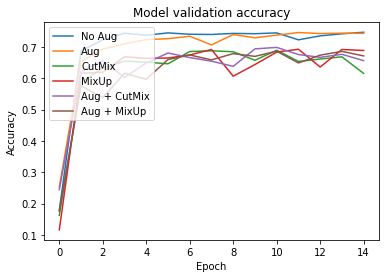

In [27]:
plt.plot(history_resnet50_no_aug.history["val_accuracy"])
plt.plot(history_resnet50_aug.history["val_accuracy"])
plt.plot(history_resnet50_cut.history["val_accuracy"])
plt.plot(history_resnet50_mix.history["val_accuracy"])
plt.plot(history_resnet50_aug_cut.history["val_accuracy"])
plt.plot(history_resnet50_aug_mix.history["val_accuracy"])
plt.title("Model validation accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(
    ["No Aug", "Aug", "CutMix", "MixUp", "Aug + CutMix", "Aug + MixUp"],
    loc="upper left",
)
plt.show()

## 성능 비교

| Augmentation | Val Acc |
| --- | --- |
| - | 0.747 |
| ✓ | 0.746 |
| CutMix | 0.690 |
| MixUp | 0.693 |
| ✓ + CutMix | 0.699 |
| ✓ + MixUp | 0.687 |

## 루브릭

| 평가문항                                             | 상세기준                                                         |
| --- | --- |
| 1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가? | CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.          |
| 2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?  | Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함     |
| 3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가? | 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다. |

### 루브릭 자체평가

1. 여러 가지 데이터 증강 방법을 적용한 모델의 학습을 진행하였다.
2. 데이터 증강 기법을 적용한 경우, 그렇지 않은 경우와 비교하여 성능 향상을 이루지 못하였다.
3. 데이터 증강 기법을 적용한 경우와 그렇지 않은 여러 가지 경우의 모델의 성능을 시각적으로 비교하였다.